

# Mixed Effects Model

Do a Random slopes models, where the responses in a group follow a (conditional) mean trajectory that is linear in the observed covariates, with the slopes (and possibly intercepts) varying by group.

Goal, identify diferent spread rates by county, state, region

https://www.statsmodels.org/stable/examples/notebooks/generated/mixed_lm_example.html

References¶
The primary reference for the implementation details is:

MJ Lindstrom, DM Bates (1988). Newton Raphson and EM algorithms for linear mixed effects models for repeated measures data. Journal of the American Statistical Association. Volume 83, Issue 404, pages 1014-1022.

A model with two nested grouping factors: section 3
http://econ.ucsb.edu/~doug/245a/Papers/Mixed%20Effects%20Implement.pdf

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf



# Read in Design Matrix

In [2]:
design_matrix = pd.read_csv("design_matrix.csv")

# Prepare 

In [3]:
# Prepare for linear regression


# drop columns
cols_to_drop = ["cases", "date", "deaths"]######, "FIPS"]

design_matrix_for_reg = design_matrix.drop(columns= cols_to_drop)

# Set fips to string to not be altered
design_matrix_for_reg["FIPS"] = design_matrix_for_reg["FIPS"].astype("str")
# DO NOT one-hot encode state
#design_matrix_for_reg = pd.get_dummies(design_matrix_for_reg, columns=["state"])

# fill na's with state mean for pollutants
design_matrix_for_reg[["NO2 AQI", "O3 AQI", "SO2 AQI", "CO AQI"]]  = \
    design_matrix[["state", "NO2 AQI", "O3 AQI", "SO2 AQI", "CO AQI"]].groupby(
    "state").transform(lambda x: x.fillna(x.mean())).reset_index()[["NO2 AQI", "O3 AQI", "SO2 AQI", "CO AQI"]]

# fill na's with no state with national mean from other readings
design_matrix_for_reg[["NO2 AQI", "O3 AQI", "SO2 AQI", "CO AQI"]] = \
design_matrix_for_reg[["NO2 AQI", "O3 AQI", "SO2 AQI", "CO AQI"]].fillna(design_matrix.mean())

# impute nan county vmt with jan_avg_vmt
design_matrix_for_reg.loc[
    design_matrix_for_reg.county_vmt.isna(), "county_vmt"] = \
design_matrix_for_reg["jan_avg_vmt"]

In [4]:
# drop na's
#####design_matrix_for_reg = pd.read_csv("design_matrix_for_linear_regression.csv")
design_matrix_lr = design_matrix_for_reg.dropna()

In [5]:
# drop columns
#print(design_matrix_lr.columns)
cols_to_drop = ["Unnamed: 0", "new_deaths"] #"Unnamed: 0.1"
design_matrix_lr = design_matrix_lr.drop(columns = cols_to_drop)

# Data Transformation

In [6]:
pop_feat_columns = ["population", "jan_avg_vmt", "county_vmt"]

pop_case_columns = ['new_cases', 'new_cases_prev_5_days', 'new_deaths_prev_5_days',
       'new_cases_prev_7_days', 'new_deaths_prev_7_days',
       'new_cases_prev_14_days', 'new_deaths_prev_14_days']

#np.log(design_matrix_lr.iloc[:,:-51] + 1).hist(figsize = (15, 20), xrot = 0.2);

# divide population columns by population (per person)
des_mat = design_matrix_lr.copy()
# make it new cases per 100,000 people to be readable
des_mat.loc[:, pop_case_columns] = np.log(des_mat.loc[:, pop_case_columns].divide(des_mat.loc[:, "population"], axis = "index") * 100000 + 1)
des_mat.loc[:, pop_feat_columns] = np.log(des_mat.loc[:, pop_feat_columns].divide(des_mat.loc[:, "population"], axis = "index") + 1)
des_mat = des_mat.drop(columns="population")
# square root of cit accessibility
des_mat["city_accessibility"] = np.sqrt(des_mat.loc[:,"city_accessibility"])

In [7]:
# remove white space with underscores for modeling
des_mat.columns = des_mat.columns.str.replace(' ', '_')
# remove commas as well
des_mat.columns = des_mat.columns.str.replace(',', '')
des_mat.dtypes

state                                                                        object
median_age                                                                  float64
female_percentage                                                           float64
FIPS                                                                         object
city_accessibility                                                          float64
NO2_AQI                                                                     float64
O3_AQI                                                                      float64
SO2_AQI                                                                     float64
CO_AQI                                                                      float64
jan_avg_vmt                                                                 float64
county_vmt                                                                  float64
Category_Diarrhea_lower_respiratory_and_other_common_infectious_diseases    

# Modeling

### nested example: https://www.statsmodels.org/stable/generated/statsmodels.regression.mixed_linear_model.MixedLM.from_formula.html

https://stackoverflow.com/questions/47502398/python-statsmodels-mixedlm-mixed-linear-model-random-effects

# Load design matrix

In [2]:
# SAVE
#des_mat.to_csv("design_matrix_lme.csv")

# LOAD 
des_mat = pd.read_csv("design_matrix_lme.csv")

In [3]:
cols_l1 = ['median_age', 'city_accessibility', 'jan_avg_vmt',
       'county_vmt', 'Category_Chronic_respiratory_diseases',
       'new_cases_prev_1_days', 'new_cases_prev_5_days',
       'new_deaths_prev_5_days', 'new_cases_prev_7_days',
       'new_cases_prev_14_days', 'new_school_measure_7_14_days_ago',
       'new_soc_dist_measure_7_14_days_ago',
       'new_school_measure_14_21_days_ago',
       'new_soc_dist_measure_14_21_days_ago']

cols_l1.append("state")

# For scope reasons, chose these methods to curtail

In [5]:
re_form = """C(0 + city_accessibility) + (0 + jan_avg_vmt) + 
(0 + county_vmt) + (0 + Category_Chronic_respiratory_diseases)+ (0 + new_school_measure_7_14_days_ago) + 
(0 + new_soc_dist_measure_7_14_days_ago) + (0 + new_school_measure_14_21_days_ago) + 
(0 + new_soc_dist_measure_14_21_days_ago)"""


In [ ]:
# X and Y
X = des_mat.drop(columns=["new_cases"]) # here we have 2 variables for the multiple linear regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example
# make it new cases per 100,000 people to be readable
y = des_mat['new_cases']

# normalize for sensible results
X.loc[:, X.dtypes != "object"]=(X.loc[:, X.dtypes != "object"]- \
                                X.loc[:, X.dtypes != "object"].mean())/ \
                                X.loc[:, X.dtypes != "object"].std()

# fill flat distributions with 0
X = X.fillna(0)

# filter out columns with coefficients of 0 in lasso
X = X[cols_l1]

X["new_cases"] = y

# train_test split
train, test, = train_test_split(
    X, test_size=0.1, random_state=42)

# list of features to use for model
feature_string = ""
#re_form = ""
feats_to_use = list(train.columns[1:4]) + list(train.columns[4:-1])
for feat in train.columns[:-2]:#feats_to_use:
    if feat == train.columns[-3]:#feats_to_use[-1]:    
        feature_string = feature_string + "{}".format(feat)
        #re_form = re_form + "(0 + {})".format(feat)
    elif feat == "FIPS":
        pass#feature_string = feature_string + "C({}) + ".format(feat)
    else:
        feature_string = feature_string + "{} + ".format(feat)
        #re_form = re_form + "(0 + {}) + ".format(feat)

# make model
md = smf.mixedlm("new_cases ~ {}".format(feature_string), train, re_formula = re_form, groups=train["state"])
#model = sm.OLS(endog = y_train, exog = X_train).fit_regularized(method = "elastic_net", alpha = 0.01, L1_wt = 1, refit = True)

#print_model = model.summary()
#print_model

In [ ]:
# Fit model
mdf = md.fit()

In [7]:
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Mixed Linear Model Regression Results
===========================================================================================================================
Model:                                   MixedLM                      Dependent Variable:                      new_cases   
No. Observations:                        126223                       Method:                                  REML        
No. Groups:                              49                           Scale:                                   0.3607      
Min. group size:                         40                           Likelihood:                              -115174.6541
Max. group size:                         10351                        Converged:                               Yes         
Mean group size:                         2576.0                                                                            
---------------------------------------------------------------------------------------------------------------------------
                                                                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                                        0.377    0.004  92.305 0.000  0.369  0.385
median_age                                                                      -0.034    0.002 -17.776 0.000 -0.038 -0.030
city_accessibility                                                              -0.059    0.008  -7.325 0.000 -0.075 -0.043
jan_avg_vmt                                                                      0.063    0.011   5.979 0.000  0.042  0.083
county_vmt                                                                      -0.084    0.014  -6.047 0.000 -0.111 -0.056
Category_Chronic_respiratory_diseases                                           -0.023    0.006  -3.965 0.000 -0.034 -0.012
new_cases_prev_1_days                                                            0.026    0.002  14.104 0.000  0.023  0.030
new_cases_prev_5_days                                                            0.111    0.008  14.188 0.000  0.096  0.126
new_deaths_prev_5_days                                                           0.058    0.002  23.765 0.000  0.053  0.062
new_cases_prev_7_days                                                            0.118    0.011  11.224 0.000  0.097  0.139
new_cases_prev_14_days                                                           0.204    0.007  28.324 0.000  0.190  0.218
new_school_measure_7_14_days_ago                                                -0.016    0.014  -1.119 0.263 -0.044  0.012
new_soc_dist_measure_7_14_days_ago                                               0.058    0.010   5.503 0.000  0.037  0.078
new_school_measure_14_21_days_ago                                               -0.015    0.017  -0.843 0.399 -0.049  0.020
new_soc_dist_measure_14_21_days_ago                                              0.068    0.011   6.332 0.000  0.047  0.089
city_accessibility Var                                                           0.003    0.001                            
city_accessibility x jan_avg_vmt Cov                                            -0.001    0.001                            
jan_avg_vmt Var                                                                  0.004    0.002                            
city_accessibility x county_vmt Cov                                              0.001    0.001                            
jan_avg_vmt x county_vmt Cov                                                    -0.005    0.002                            
county_vmt Var                                                                   0.008    0.003                            
city_accessibility x Categ

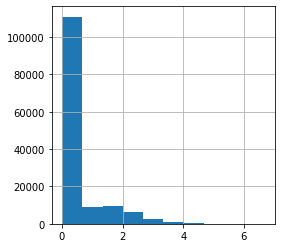

In [12]:
X["new_cases"].hist(figsize=(4,4));

In [14]:
mdf.fe_params

Intercept                                0.377067
median_age                              -0.034275
city_accessibility                      -0.058873
jan_avg_vmt                              0.062789
county_vmt                              -0.083545
Category_Chronic_respiratory_diseases   -0.022752
new_cases_prev_1_days                    0.026478
new_cases_prev_5_days                    0.110956
new_deaths_prev_5_days                   0.057560
new_cases_prev_7_days                    0.118004
new_cases_prev_14_days                   0.203798
new_school_measure_7_14_days_ago        -0.015949
new_soc_dist_measure_7_14_days_ago       0.057559
new_school_measure_14_21_days_ago       -0.014717
new_soc_dist_measure_14_21_days_ago      0.067698
dtype: float64